We will use xgboost boost as our learners

In [0]:
!pip install xgboost

Needed imports

In [0]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
import matplotlib.pyplot as plt

**Data preparation**

In [68]:
# Wave choosing
wc = lambda x: np.logical_or((np.logical_and(x <= 11, x >= 6)), x<=4)
waves = [i for i in range(1, 5)] + [i for i in range(6, 12)]
# Treatment label
tl = 'attr'
# Loading data
data = pd.read_csv('Speed Dating Data.csv', encoding="ISO-8859-1")
data = data[wc(data['wave'].to_numpy())]
print('Number of unit without outcome:', data['dec'].isna().sum())
data = data[data['dec'].notna()]
print('Number of unit without treatment:', data[tl].isna().sum())
data = data[data[tl].notna()]
# Droping followup questions answers 
data = data.drop(columns=list(data)[108:])
# Droping identifier (exsept the iid that will be dropped later)
# and post treatment features
data = data.drop(columns=['id', 'idg', 'partner', 'pid', 'like', 'match',
                          'match_es', 'dec_o', 'like_o', 'attr_o', 'sinc_o', 
                          'intel_o', 'fun_o', 'amb_o', 'shar_o'])
# String feature will be sparse if we covert them to one hot and are dicretcized
# by other features
str_list = ['field', 'from', 'career', 'undergra']
data = data.drop(columns=str_list)
# Categorial features will be coverted to onehot
cat_list = ['career_c', 'field_cd']
for l in cat_list:
    one_hot = pd.get_dummies(data[l], prefix=l)
    data = pd.concat([data, one_hot], axis=1)
    data = data.drop(columns=[l])
# Numeric features
num_list = ['mn_sat', 'income', 'tuition','zipcode']
for n in num_list:
    data[n] = data[n].astype(str).str.replace(',', '')
    data[n] = data[n].astype(float)
# Binarizing treatment and seperating from the features
t = (data[tl] >= 7).to_numpy(dtype=int)
data = data.drop(columns=[tl])
# number of observation
print('Number of observation:', len(t))
# Seperating the outcome from the features
y = data['dec'].to_numpy()
data = data.drop(columns=['dec'])
# Seperating the individual id's from the features
iid = data['iid'].to_numpy()
data = data.drop(columns=['iid'])
# Seperating the wave from the features
wave = data['wave'].to_numpy()
data = data.drop(columns=['wave'])
# Indexing fearture back from zero
X = data.reset_index(drop=True)
# True for indexes of female subject
female = X['gender'] == 0
# True for indexes of male subject
male = X['gender'] == 1
# Number of features
print('Number of features:', len(list(X)))

Number of unit without outcome: 0
Number of unit without treatment: 32
Number of observation: 4230
Number of features: 112


**Checking treatment balancing.**

Note the gender is of the one who make the decision.

In [3]:
print('precent of treated', '{p: 2.2f}%'.format(p=np.sum(t == 1)/len(t)*100))
print('precent of treated among the men', '{p: 2.2f}%'.format(p=np.sum(t[male] == 1)/len(t[male])*100))
print('precent of treated among the women', '{p: 2.2f}%'.format(p=np.sum(t[female] == 1)/len(t[female])*100))

precent of treated  44.94%
precent of treated among the men  51.73%
precent of treated among the women  38.18%


**Propensity score**

Hyper paramerter tuning

In [0]:
def grid_search_prop(X, t, wave):
    '''Does a grid search for propensity score model 
    with the waves as the folds of the cross vlidation
    printing the prameters the auc of the best model, 
    and returns the best premeters .
    '''
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'max_delta_step': [0, 1],
        'max_depth': [2, 3, 4],
        'n_estimators': [10, 20, 30]
    }
    model = XGBClassifier(n_jobs=1)
    X = X.reset_index(drop=True)
    wave_cv = [(np.where(wave == w)[0], np.where(wave != w)[0]) for w in waves]
    gs = GridSearchCV(model, params, scoring='roc_auc', n_jobs=4, cv=wave_cv,
                      verbose=1)
    gs.fit(X, t)
    print('best parmeters:', gs.best_params_)
    print('AUC', gs.best_score_)
    return gs.best_params_

# Propensity score parmeters for the entire population
print('For the entire population:')
pp = grid_search_prop(X, t, wave)
# Propensity score parmeters for the male
print('For the men:')
ppm = grid_search_prop(X[male], t[male], wave[male])
# Propensity score parmeters for the female
print('For the women:')
ppf = grid_search_prop(X[female], t[female], wave[female])

For the entire population:
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   39.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  1.7min finished


best parmeters: {'gamma': 2, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 30}
AUC 0.7334168157800507
For the men:
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   43.9s
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


best parmeters: {'gamma': 1, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 20}
AUC 0.6970210606167898
For the women:
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   24.7s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   45.1s


best parmeters: {'gamma': 1.5, 'max_delta_step': 1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 20}
AUC 0.7000116491435124


[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  1.0min finished


Pre computed hyper parameter

In [0]:
pp = {'gamma': 2, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 30}
ppm = {'gamma': 1, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 20}
ppf = {'gamma': 1.5, 'max_delta_step': 1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 20}

Propensity score estimation.

During the estimation we can trim based on the propensity score which can be also use by the over estimators

In [0]:
def prop(X, t, trim=False, pp=None):
    '''Computes propensity score estimations on X and t with parameters pp.
    If trim is False X, t, p, ov will be returned when X, t is the given
    X, t. p will be the propensity score estimation and ov will be None.
    If trim is True X, t, p, ov will be returned when X, t are the trimmed X, t
    p is the trimmed propensity score estimation and ov boolean nparray that 
    will be true for untrimmed indexs.
    '''
    xgb = XGBClassifier(**pp, n_jobs=-1)
    xgb.fit(X, t)
    p = xgb.predict_proba(X)[:, 1]
    ov = None
    if trim:
        up = np.min([np.max(p[t == 0]), np.max(p[t == 1])])
        low = np.max([np.min(p[t == 0]), np.min(p[t == 1])])
        ov = np.logical_and(p <= up, p >= low)
        X, t, p = X[ov], t[ov], p[ov]
    return X, t, p, ov



Overlap plot using the propensity score

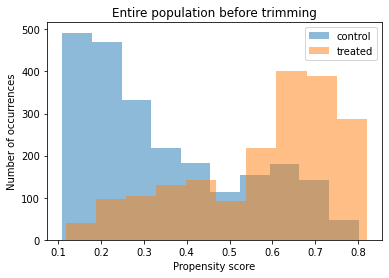

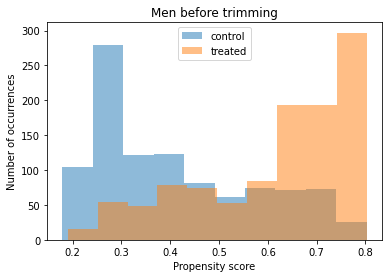

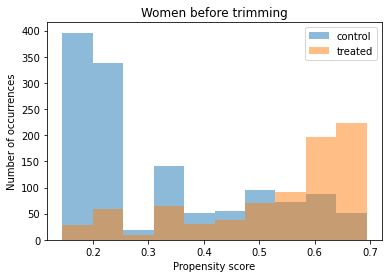

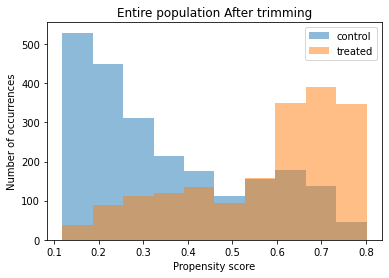

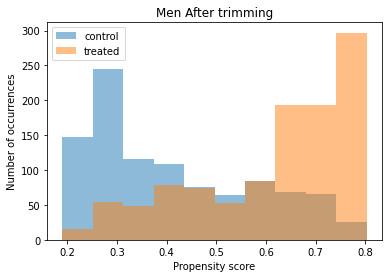

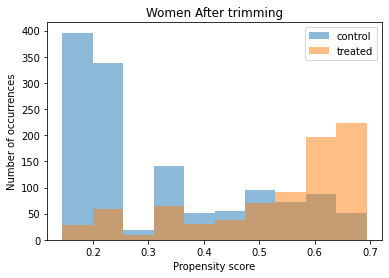

precent of trimmed:  2.03%
precent of trimmed in the men:  0.90%
precent of trimmed in the women:  0.00%


In [6]:
def plot_prop(X, t, trim=False, title='', pp=None):
    '''plots overlap plot using the propensity score.
    pp are the hyper prameter used and title is the title of the plot
    '''
    _, t, p, _ = prop(X, t, trim, pp=pp)
    pc = p[t == 0]
    pt = p[t == 1]
    plt.hist(pc, alpha=0.5, density=False, label='control')
    plt.hist(pt, alpha=0.5, density=False, label='treated')
    plt.xlabel('Propensity score')
    plt.ylabel('Number of occurrences')
    plt.legend()
    plt.title(title)
    plt.show()

plot_prop(X, t, title='Entire population before trimming', trim=False, pp=pp)
plot_prop(X[male], t[male], title='Men before trimming',
          trim=False, pp=ppm)
plot_prop(X[female], t[female], title='Women before trimming',
          trim=False, pp=ppf)
plot_prop(X, t, title='Entire population After trimming', trim=True, pp=pp)
plot_prop(X[male], t[male], title='Men After trimming',
          trim=True, pp=ppm)
plot_prop(X[female], t[female], title='Women After trimming',
          trim=True, pp=ppf)

# finding precent of trimmed
ove = prop(X, t, trim=True, pp=pp)[3]
print('precent of trimmed:', '{p: 2.2f}%'.format(p=(1 - ove.sum()/len(ove))*100))
# finding precent of trimmed
ovm = prop(X[male], t[male], trim=True, pp=ppm)[3]
print('precent of trimmed in the men:', '{p: 2.2f}%'.format(p=(1 - ovm.sum()/len(ovm))*100))
ovf = prop(X[female], t[female], trim=True, pp=ppf)[3]
print('precent of trimmed in the women:', '{p: 2.2f}%'.format(p=(1 - ovf.sum()/len(ovf))*100))


Inverse Propensity weighting

In [69]:
def iptw(X, t, y, pp, trim=True):
    _, t, e, ov = prop(X, t, trim, pp)
    y = y[ov]
    w1 = 1 / np.sum(t / e)
    w0 = 1 / np.sum((1 - t) / (1 - e))
    ate1 = np.sum(y * t / e)
    ate0 = np.sum(y * (1 - t) / (1 - e))
    return w1 * ate1 - w0 * ate0

print('IPTW ATE estimation for the entire population:')
print('ATE =', iptw(X, t, y, trim=True, pp=pp))
print('IPTW ATE estimation for the men:')
print('ATE = ', iptw(X[male], t[male], y[male], trim=True, pp=ppm))
print('IPTW ATE estimation for the women:')
print('ATE = ', iptw(X[female], t[female], y[female], trim=True, pp=ppf))

IPTW ATE estimation for the entire population:
ATE = 0.3413150927335008
IPTW ATE estimation for the men:
ATE =  0.38139762908711156
IPTW ATE estimation for the women:
ATE =  0.32443409692615716


S learner

In [35]:
def grid_search_s(X, t, y, pp,trim=True):
    if trim:
        X, t, _, ov = prop(X, t, pp=pp, trim=True)
        y = y[ov]
    # The colsample was hand chosen to not reduce (significantly) the AUC
    # while being as low as possible, going above 400 estimators does not
    # significantly improve preformence but significantly impact the run time
    params = {
        'colsample_bytree':[0.5],
        'colsample_bylevel':[0.1],
        'colsample_bynode':[0.2],
        'learning_rate': [0.2],
        'max_depth': [3, 4, 5, 6],
        'n_estimators': [300, 400]
    }
    X = X.reset_index(drop=True)
    nf = len(list(X))
    stacked_t = np.transpose(np.tile(t, (nf + 1, 1)))
    Xt = pd.concat([X, pd.DataFrame(stacked_t)], axis=1)
    model = XGBClassifier(n_jobs=1)
    cv = KFold(shuffle=True, random_state=42)
    gs = GridSearchCV(model, params, scoring='roc_auc', n_jobs=4, cv=cv,
                       verbose=1)
    gs.fit(Xt, y)
    print('best parmeters:', gs.best_params_)
    print('best AUC:', gs.best_score_)
    return gs.best_params_

# S learner parmeters for the entire population
print('For the entire population:')
ps = grid_search_s(X, t, y, pp)
# S learner parmeters for the men
print('For the men:')
psm = grid_search_s(X[male], t[male], y[male], ppm)
# S learner parmeters for the women
print('For the women:')
psf = grid_search_s(X[female], t[female], y[female], ppf)

For the entire population:
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   39.7s finished


best parmeters: {'colsample_bylevel': 0.1, 'colsample_bynode': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 400}
best AUC: 0.9057664587044651
For the men:
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   20.5s finished


best parmeters: {'colsample_bylevel': 0.1, 'colsample_bynode': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 400}
best AUC: 0.9111388819474829
For the women:
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   20.8s finished


best parmeters: {'colsample_bylevel': 0.1, 'colsample_bynode': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 400}
best AUC: 0.8991704778679221


Pre computed parameters

In [0]:
ps = {'colsample_bylevel': 0.1, 'colsample_bynode': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 400}
psm = {'colsample_bylevel': 0.1, 'colsample_bynode': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 400}
psf = {'colsample_bylevel': 0.1, 'colsample_bynode': 0.2, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 400}

Finding ATE

In [37]:
def s_learner_ate(X, t, y, pp, ps, trim=True):
    if trim:
        X, t, _, ov = prop(X, t, pp=pp,trim=True)
        y = y[ov]
    X = X.reset_index(drop=True)
    nf = len(list(X))
    stacked_t = np.transpose(np.tile(t, (nf + 1, 1)))
    Xt = pd.concat([X, pd.DataFrame(stacked_t)], axis=1)
    X0 = pd.concat([X, pd.DataFrame(np.zeros((len(t), nf + 1)))], axis=1)
    X1 = pd.concat([X, pd.DataFrame(np.ones((len(t), nf + 1)))], axis=1)
    xgb = XGBClassifier(**ps, n_jobs=-1)
    xgb.fit(Xt, y)
    return np.mean(xgb.predict_proba(X1)[:, 1] - xgb.predict_proba(X0)[:, 1])

print('For the entire population:')
print('ATE = ', s_learner_ate(X, t, y, pp=pp, ps=ps))
print('For the men:')
print('ATE = ', s_learner_ate(X[male], t[male], y[male],
                              pp=ppm, ps=psm))
print('For the women:')
print('ATE = ', s_learner_ate(X[female], t[female], y[female],
                              pp=ppf, ps=psf))

For the entire population:
ATE =  0.29176554
For the men:
ATE =  0.32108483
For the women:
ATE =  0.27316675


T learner

In [0]:
def grid_search_t(X, t, y, pp,trim=True):
    if trim:
        X, t, _, ov = prop(X, t, pp=pp, trim=True)
        y = y[ov]
    params = {
        'gamma': [0.5, 1, 1.5, 2],
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5],
        'n_estimators': [40, 60, 80]
    }
    model1 = XGBClassifier(n_jobs=1)
    X1 = X[t==1].reset_index(drop=True)
    cv = KFold(shuffle=True, random_state=42)
    gs1 = GridSearchCV(model1, params, scoring='roc_auc', n_jobs=4, cv=cv,
                       verbose=1)
    gs1.fit(X1, y[t == 1])
    print('best parmeters for the treated:', gs1.best_params_)
    print('best AUC for the treated:', gs1.best_score_)
    pt1 = gs1.best_params_
    model0 = XGBClassifier(n_jobs=1)
    X0 = X[t==0].reset_index(drop=True)
    gs0 = GridSearchCV(model0, params, scoring='roc_auc', n_jobs=4, cv=cv,
                       verbose=1)
    gs0.fit(X[t == 0], y[t == 0])
    print('best parmeters for the control:', gs0.best_params_)
    print('best AUC for the control:', gs0.best_score_)
    pt0 = gs0.best_params_
    return pt0, pt1

# T learner parmeters for the entire population
print('For the entire population:')
pt0, pt1 = grid_search_t(X, t, y, pp)
# T learner parmeters for the male
print('For the men:')
ptm0, ptm1 = grid_search_t(X[male], t[male], y[male], ppm)
# T learner parmeters for the female
print('For the women:')
ptf0, ptf1 = grid_search_t(X[female], t[female], y[female], ppf)

For the entire population:
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  3.5min finished


best parmeters for the treated: {'gamma': 1, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 80}
best AUC for the treated: 0.8497052497811453
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  4.1min finished


best parmeters for the control: {'gamma': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 40}
best AUC for the control: 0.8574959616329633
For the men:
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   38.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.8min finished


best parmeters for the treated: {'gamma': 2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40}
best AUC for the treated: 0.8629286030228773
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


best parmeters for the control: {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60}
best AUC for the control: 0.858084587059999
For the women:
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


best parmeters for the treated: {'gamma': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 80}
best AUC for the treated: 0.8358640327018234
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.4min finished


best parmeters for the control: {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 80}
best AUC for the control: 0.8629590118944115


pre computed parmeters

In [0]:
pt0 = {'gamma': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 40}
pt1 = {'gamma': 1, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 80}
ptm0 =  {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 60}
ptm1 = {'gamma': 2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 40}
ptf0 = {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 80}
ptf1 = {'gamma': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 80}

Finding ATE

In [39]:
def t_learner_ate(X, t, y, pp, pt0, pt1, trim=True):
    if trim:
        X, t, _, ov = prop(X, t, pp=pp,trim=True)
        y = y[ov]
    xgb1 = XGBClassifier(**pt1, n_jobs=-1)
    xgb1.fit(X[t == 1], y[t == 1])
    xgb0 = XGBClassifier(**pt0, n_jobs=-1)
    xgb0.fit(X[t == 0], y[t == 0])
    return np.mean(xgb1.predict_proba(X)[:, 1] - xgb0.predict_proba(X)[:, 1])

print('For the entire population:')
print('ATE = ', t_learner_ate(X, t, y, pp=pp, pt0=pt0, pt1=pt1))
print('For the men:')
print('ATE = ', t_learner_ate(X[male], t[male], y[male],
                              pp=ppm, pt0=ptm0, pt1=ptm1))
print('For the women:')
print('ATE = ', t_learner_ate(X[female], t[female], y[female],
                              pp=ppf, pt0=ptf0, pt1=ptf1))


For the entire population:
ATE =  0.29964003
For the men:
ATE =  0.32019448
For the women:
ATE =  0.2791014


Doubly roubust

With T learner

In [40]:
def dr_t_ate(X, t, y, pp, pt0, pt1, trim=True, return_orig=False):
    # if return_orig is True the function will return both the original learner
    # ate and the dr ate
    X, t, e, ov = prop(X, t, pp=pp, trim=trim)
    if trim:
        y = y[ov]
    xgb1 = xgb = XGBClassifier(**pt1, n_jobs=-1)
    xgb1.fit(X[t == 1], y[t == 1])
    xgb0 = xgb = XGBClassifier(**pt0, n_jobs=-1)
    xgb0.fit(X[t == 0], y[t == 0])
    m1 = xgb1.predict_proba(X)[:, 1]
    m0 = xgb0.predict_proba(X)[:, 1]
    if return_orig:
        return np.mean(m1 - m0), np.mean(m1 - (t / e) * (m1 - y) - m0 + ((1 - t) / (1 - e)) * (m0 - y))
    return np.mean(m1 - (t / e) * (m1 - y) - m0 + ((1 - t) / (1 - e)) * (m0 - y))

print('For the entire population:')
print('ATE = ', dr_t_ate(X, t, y, pp=pp, pt0=pt0, pt1=pt1))
print('For the men:')
print('ATE = ', dr_t_ate(X[male], t[male], y[male],
                              pp=ppm, pt0=ptm0, pt1=ptm1))
print('For the women:')
print('ATE = ', dr_t_ate(X[female], t[female], y[female],
                              pp=ppf, pt0=ptf0, pt1=ptf1))


For the entire population:
ATE =  0.29516478219667736
For the men:
ATE =  0.31219418044410197
For the women:
ATE =  0.2715234792909312


With S learner

In [41]:
def dr_s_ate(X, t, y, pp, ps, trim=True, return_orig=False):
    # if return_orig is True the function will return both the original learner
    # ate and the dr ate
    if trim:
        X, t, e, ov = prop(X, t, pp=pp,trim=True)
        y = y[ov]
    X = X.reset_index(drop=True)
    nf = len(list(X))
    stacked_t = np.transpose(np.tile(t, (nf + 1, 1)))
    Xt = pd.concat([X, pd.DataFrame(stacked_t)], axis=1)
    X0 = pd.concat([X, pd.DataFrame(np.zeros((len(t), nf + 1)))], axis=1)
    X1 = pd.concat([X, pd.DataFrame(np.ones((len(t), nf + 1)))], axis=1)
    xgb = XGBClassifier(**ps, n_jobs=-1)
    xgb.fit(Xt, y)
    m1 = xgb.predict_proba(X1)[:, 1]
    m0 = xgb.predict_proba(X0)[:, 1]
    if return_orig:
        return np.mean(m1 - m0), np.mean(m1 - (t / e) * (m1 - y) - m0 + ((1 - t) / (1 - e)) * (m0 - y))
    return np.mean(m1 - (t / e) * (m1 - y) - m0 + ((1 - t) / (1 - e)) * (m0 - y))

print('For the entire population:')
print('ATE = ', dr_s_ate(X, t, y, pp=pp, ps=ps))
print('For the men:')
print('ATE = ', dr_s_ate(X[male], t[male], y[male],
                              pp=ppm, ps=psm))
print('For the women:')
print('ATE = ', dr_s_ate(X[female], t[female], y[female],
                              pp=ppf, ps=psf))


For the entire population:
ATE =  0.28592860501413475
For the men:
ATE =  0.31298555047436716
For the women:
ATE =  0.2650678593256518


**Bootstrap**

The bias is computed by the mean of the bootstrap minus our estimation of the ate.

**NOTE**: ignore the men vs women confidence interval we made a mistake during their construction and they does not appear in the report either

In [0]:
def print_bootstrap_results(label, ate_est, res, a=(0.1, 0.05)):
    print(label)
    mean = res.mean()
    print('estimate on the entire data:', ate_est)
    print('boostrap mean:', mean)
    print('estimated bias:', mean - ate_est)
    d = ate_est - res
    for conf in a:
        print('confidence interval at level ',
              '{p: 2d}%'.format(p=int((1-conf)*100)),
              ': [', ate_est + np.quantile(d, conf/2, interpolation='midpoint'),
              ',', mean + np.quantile(d, 1-conf/2, interpolation='midpoint'), ']')
    print('')


def bootstrap_ate(estimator, estimators_param, X_list, t_list, y_list, wave_list, 
                  waves=waves, dr=False, n=999, a=(0.1, 0.05)):
    '''This function will print out bootstrap statistics with n replications 
    for the entire population, the men and the women using estimator 
    were estimators_param is a list of parmaters for use of estimator for 
    each population. X_list, t_list, y_list, wave_list are list of features,
    tereatment, outcome, and wave for each poulation. if dr is True the doubly 
    roubast will be printed to used only the estimator has doubly roubast version
    with that version. a is the alpha values for the confidence intervals.'''
    ate_est_list = []
    label_list = ['For the entire population',
                  'For the men',
                  'For the women']
    if not dr:
        res_list = [np.zeros(n), np.zeros(n), np.zeros(n)]
    else:
        res_list = [(np.zeros(n), np.zeros(n)), (np.zeros(n), np.zeros(n)),
                   (np.zeros(n), np.zeros(n))]
    group_iter = zip(X_list, t_list, y_list, wave_list, 
                     estimators_param, res_list, label_list)
    for X, t, y, wave, estimator_param, res, l in group_iter:
        if not dr:
            ate_est = estimator(X, t, y, **estimator_param)
            ate_est_list.append(ate_est)
        else:
            ate_est = estimator(X, t, y, **estimator_param)
            ate_est_list.append(ate_est)
        waves = np.array(waves)
        m = len(waves)
        X = X.reset_index(drop=True)
        for i in range(n):
            sample_waves = waves[np.random.randint(m, size=m)]
            sample_ind = np.isin(wave, sample_waves)
            Xs, ts, ys = X[sample_ind], t[sample_ind], y[sample_ind]
            Xs = Xs.reset_index(drop=True)
            if not dr:
                res[i] = estimator(Xs, ts, ys, **estimator_param)
            else:
                res[0][i], res[1][i] = estimator(Xs, ts, ys, **estimator_param)
        if not dr:
            print_bootstrap_results(l+':', ate_est, res, a=a)
        if dr:
            print_bootstrap_results(l+' without doubly roubast:',
                                    ate_est[0], res[0], a=a)
            print_bootstrap_results(l+' with doubly roubast:',
                                    ate_est[1], res[1], a=a)
    l = 'Differnce between men and women ATE'
    if not dr:
        print_bootstrap_results(l+':', ate_est_list[1] - ate_est_list[2],
                                res_list[1] - res_list[2], a=a)
    else:
        print_bootstrap_results(l+' without doubly roubast:',
                                ate_est_list[1][0] - ate_est_list[2][0],
                                res_list[1][0] - res_list[2][0], a=a)
        print_bootstrap_results(l+' with doubly roubast:',
                                ate_est_list[1][1] - ate_est_list[2][1],
                                res_list[1][1] - res_list[2][1], a=a) 


X_list = [X, X[male], X[female]]    
t_list = [t, t[male], t[female]]
y_list = [y, y[male], y[female]]
wave_list = [wave, wave[male], wave[female]]



For IPTW

In [65]:
p_param = [{'pp': pp}, {'pp': ppm}, {'pp': ppf}]
bootstrap_ate(iptw, p_param, X_list, t_list, y_list, wave_list)

For the entire population:
estimate on the entire data: 0.3413150927335008
boostrap mean: 0.34252927081469603
estimated bias: 0.0012141780811952274
confidence interval at level   90% : [ 0.31255467331042747 , 0.3722893739870734 ]
confidence interval at level   95% : [ 0.3078690823445418 , 0.377663697555532 ]

For the men:
estimate on the entire data: 0.38139762908711156
boostrap mean: 0.37298383863608653
estimated bias: -0.008413790451025027
confidence interval at level   90% : [ 0.33376941175441643 , 0.44126317336531284 ]
confidence interval at level   95% : [ 0.32484818772709445 , 0.4518411202856163 ]

For the women:
estimate on the entire data: 0.32443409692615716
boostrap mean: 0.31703689885288316
estimated bias: -0.007397198073273992
confidence interval at level   90% : [ 0.3047145831012093 , 0.3553054495403049 ]
confidence interval at level   95% : [ 0.2982803368042163 , 0.3612876433032176 ]

Differnce between men and women ATE:
estimate on the entire data: 0.0569635321609544
boo

For S learner

In [66]:
s_param = [{'pp': pp, 'ps': ps, 'return_orig': True},
           {'pp': ppm, 'ps': psm, 'return_orig': True},
           {'pp': ppf, 'ps': psf, 'return_orig': True}]

bootstrap_ate(dr_s_ate, s_param, X_list, t_list, y_list, wave_list, dr=True)

For the entire population without doubly roubast:
estimate on the entire data: 0.29176554
boostrap mean: 0.2998524298956683
estimated bias: 0.008086889057426716
confidence interval at level   90% : [ 0.24735912680625916 , 0.3194653382590106 ]
confidence interval at level   95% : [ 0.24267089366912842 , 0.3230198910525134 ]

For the entire population with doubly roubast:
estimate on the entire data: 0.28592860501413475
boostrap mean: 0.29356790264403154
estimated bias: 0.007639297629896791
confidence interval at level   90% : [ 0.24343931889770745 , 0.313120547148803 ]
confidence interval at level   95% : [ 0.2377023137444359 , 0.31652371757500763 ]

For the men without doubly roubast:
estimate on the entire data: 0.32108483
boostrap mean: 0.3227652335339958
estimated bias: 0.0016804063493186527
confidence interval at level   90% : [ 0.25780466198921204 , 0.37031820656599346 ]
confidence interval at level   95% : [ 0.24982194602489471 , 0.3799842322045738 ]

For the men with doubly roub

For t learner

In [67]:
t_param = [{'pp': pp, 'pt0': pt0, 'pt1': pt1, 'return_orig': True},
           {'pp': ppm, 'pt0': ptm0, 'pt1': ptm1, 'return_orig': True},
           {'pp': ppf, 'pt0': ptf0, 'pt1': ptf1, 'return_orig': True}]

bootstrap_ate(dr_t_ate, t_param, X_list, t_list, y_list, wave_list, dr=True)

For the entire population without doubly roubast:
estimate on the entire data: 0.29964003
boostrap mean: 0.3063011805156807
estimated bias: 0.006661150846872743
confidence interval at level   90% : [ 0.2597891837358475 , 0.3283438722232918 ]
confidence interval at level   95% : [ 0.2525211572647095 , 0.33323118487397235 ]

For the entire population with doubly roubast:
estimate on the entire data: 0.29516478219667736
boostrap mean: 0.3027791018522326
estimated bias: 0.007614319655555257
confidence interval at level   90% : [ 0.2537626181328777 , 0.3240214005521379 ]
confidence interval at level   95% : [ 0.24687186504229086 , 0.3290448526399704 ]

For the men without doubly roubast:
estimate on the entire data: 0.32019448
boostrap mean: 0.3299860523060874
estimated bias: 0.00979156950274268
confidence interval at level   90% : [ 0.2546180784702301 , 0.3702423737362937 ]
confidence interval at level   95% : [ 0.2479519098997116 , 0.3754125104264335 ]

For the men with doubly roubast:
es